In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [23]:
data = pd.read_csv('./healthcare-dataset-stroke-data.csv')

- Data Cleaning and EDA -- plotting each feature against target 

- Models to try -- xgboost, random forest, shallow neural net, logist reg, knn

In this dataset, we encounter imbalanced data with only 5% of the data being positive for stroke. We will try different methods to counteract this problem.

Before we begin, let's understand why this is a problem in the first place. When we work with machine learning algorithm, the model learns over time coursing through the data. It looks at the data and starts to find patterns and distinguishes between them to make predictions. We track a model's effectiveness from the accuracy of the predictions. Now, if only 5% of the data is positive, the model can learn to start predicting negative values in all cases. Thus, while the model has a 95% accuracy, it cannot catch a patient having a stroke.

We need to b able to distinguish between the false negative (when the model should predict stroke but does not) and true negative values. It is okay if the models has a few false positive values (determining stroke when the patient doesn't have one) but false negative values should be avoided completely.

In [24]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


From the data above, there are a few things to note - hypertension, heart_disease and stroke are categorical variables. We will need to analyse those separately.

### Possible Outliers:
- There seems to be something wrong with the age column since we have a value of 0.08. 
- The BMI values should not have values of 10
- Similarly, glucose levels of 55 and 270 are concerning and might need to be adjusted.
We will look at these more closely soon.


# Plan Going Forward

- Look at the outliers and why some of the values are abnormal.
- Look at the bmi levels in the data for all 'work types' and plot against stroke variable.
- Check for correlation between variables and multicollinearity
- Create categories for underweight and obese using bmi. Also diabetic categories for glucose levels
- Analyse relation between hypyertension, heart disease as compared to stroke detection and their frequency in different work types.

# Data Cleaning

In [25]:
data.drop(['id'], inplace=True, axis=1)

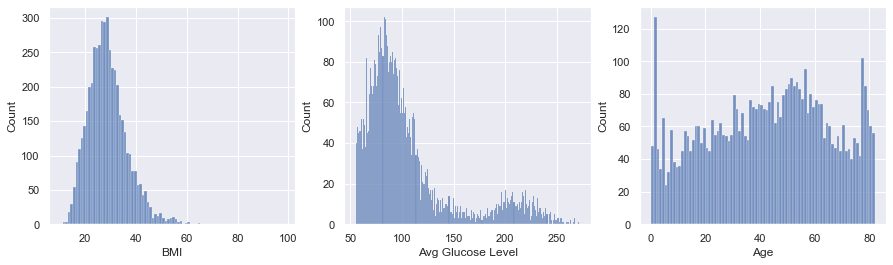

In [47]:
# Start by checking if age, bmi and glucose are guassian or parametric.

fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(15,4))

sns.histplot(data['bmi'], bins=np.arange(data['bmi'].min(), data['bmi'].max()+1), ax = ax1)
ax1.set(xlabel='BMI')
sns.histplot( data['avg_glucose_level'], bins=np.arange(data['avg_glucose_level'].min(), data['avg_glucose_level'].max()+1), ax = ax2)
ax2.set(xlabel='Avg Glucose Level')
sns.histplot(data['age'], bins=np.arange(data['age'].min(), data['age'].max()+1), ax = ax3)
ax3.set(xlabel='Age')
plt.show()

In [51]:
# BMI and Glucose Levels seem to be Normally Distributed so we will use Z-Score to find outliers. 
# However, for Age, we will use IQR.


def outlier_detection(data, category):
    mean = np.mean(data[category])
    sd = np.std(data[category])
    threshold = 2
    outliers = []
    for k, i in enumerate(data[category]): 
        z = (i-mean)/sd 
        if abs(z) > threshold: 
            outliers.append(k) 
    return data.drop(data.index[outliers])

data = outlier_detection(data, 'bmi')
data = outlier_detection(data, 'avg_glucose_level')

print(data['stroke'].value_counts())
print('--------------------------------')
print(data.shape)


0    3916
1     153
Name: stroke, dtype: int64
--------------------------------
(4069, 11)


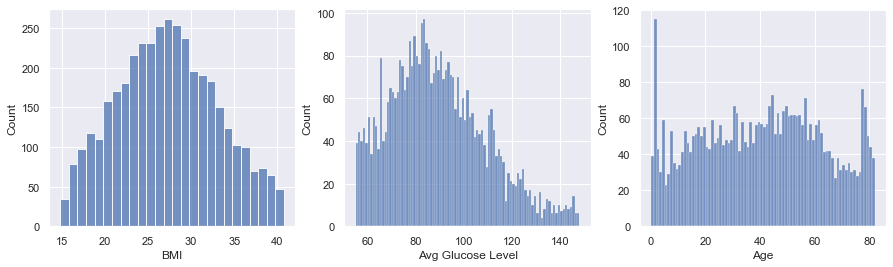

In [52]:
# Visualising the data now:
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(15,4))

sns.histplot(data['bmi'], bins=np.arange(data['bmi'].min(), data['bmi'].max()+1), ax = ax1)
ax1.set(xlabel='BMI')
sns.histplot( data['avg_glucose_level'], bins=np.arange(data['avg_glucose_level'].min(), data['avg_glucose_level'].max()+1), ax = ax2)
ax2.set(xlabel='Avg Glucose Level')
sns.histplot(data['age'], bins=np.arange(data['age'].min(), data['age'].max()+1), ax = ax3)
ax3.set(xlabel='Age')
plt.show()


In [53]:
# Now, let's move on to the age. Firstly, the age at 0 have an abnormally high number of entries. 
# Moreover, the ages are in decimal. We need to clean these values as well

display(data[data['work_type'] == 'children'].describe())
display(data[data['age'] < 3].describe())

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,627.000000,627.0,627.000000,627.000000,614.000000,627.000000
mean,6.949474,0.0,0.001595,90.535646,20.327524,0.003190
std,4.530060,0.0,0.039936,20.611736,4.379826,0.056433
min,0.080000,0.0,0.000000,55.340000,14.800000,0.000000
25%,3.000000,0.0,0.000000,75.315000,17.400000,0.000000
50%,7.000000,0.0,0.000000,88.440000,19.100000,0.000000
75%,11.000000,0.0,0.000000,105.115000,21.900000,0.000000
max,16.000000,0.0,1.000000,146.970000,40.100000,1.000000


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,154.000000,154.0,154.000000,154.000000,148.000000,154.000000
mean,1.437143,0.0,0.006494,90.296558,19.099324,0.006494
std,0.579801,0.0,0.080582,21.788002,2.847782,0.080582
min,0.080000,0.0,0.000000,55.510000,14.800000,0.000000
25%,1.020000,0.0,0.000000,73.642500,17.300000,0.000000
50%,1.640000,0.0,0.000000,88.790000,18.650000,0.000000
75%,2.000000,0.0,0.000000,109.115000,20.325000,0.000000
max,2.000000,0.0,1.000000,146.970000,33.100000,1.000000


Looking closer at the data, we find that there are over 140 entries with children aged below 3 and this was also the reason for our extremely low BMI values. The values in decimals are the months of the children who are less than 1 year old. Thus, we won't be changing anything in this column

# Data Exploration

Now, we can start creating new variables and define bmi and glucose levels as categories instead which will make it easy for the model to read.
Also, let's take a look at some possible correlations that could exist.

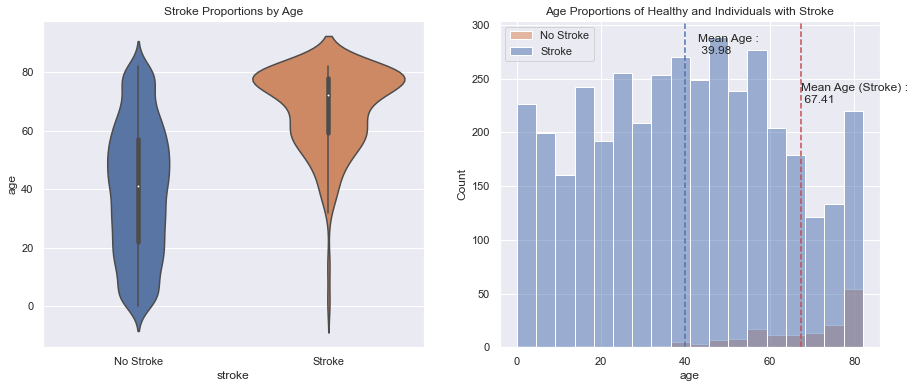

In [54]:
fig, (ax2,ax3) = plt.subplots(1,2, figsize=(15,6))

sns.violinplot(x=data['stroke'], y=data['age'], ax = ax2)
ax2.set_title('Stroke Proportions by Age')
ax2.set_xticklabels( ['No Stroke', 'Stroke'])

sns.histplot(data = data, x = 'age', hue='stroke', ax = ax3)
ax3.set_title('Age Proportions of Healthy and Individuals with Stroke')
plt.legend(loc='upper left', labels=['No Stroke', 'Stroke'])

miny_lim, y_lim = plt.ylim()
ax3.axvline(data[data['stroke']==1]['age'].mean(), linestyle='--', color='r')
ax3.axvline(data[data['stroke']==0]['age'].mean(), linestyle='--')
ax3.text(s = f"Mean Age (Stroke) : \n {data[data['stroke']==1]['age'].mean():.2f}",
         y = y_lim * 0.75, x =data[data['stroke']==1]['age'].mean() )
ax3.text(s = f"Mean Age : \n {data[data['stroke']==0]['age'].mean():.2f}",
         y = y_lim * 0.9, x =data[data['stroke']==0]['age'].mean()+3 )

plt.show()


In [55]:
# Note: The BMI index works as a range in combination with height and weight. Since we don't have these parameters, we will be avergaing the range and applying the BMI value.
# 0 - Underweight; 1 - Healthy; 2 - Overweight; 3 - Obese
data['obesity'] = 0
data['obesity'].loc[ data['bmi'] > 18 ] = 1
data['obesity'].loc[ data['bmi'] > 25 ] = 2
data['obesity'].loc[ data['bmi'] > 30 ] = 3

# 0 - Low; 1 - Normal; 2 - Diabetic
data['diabetic'] = 0
data['diabetic'].loc[ data['avg_glucose_level'] > 60 ] = 1
data['diabetic'].loc[ data['avg_glucose_level'] > 125 ] = 2

data['married'] = 0
data['married'].loc[ data['ever_married'] ==  'Yes' ] = 1

/Users/harshjhunjhunwala/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Now that all our data is categorical, let's one hot encode them. Of course, we are increasing the dimensionality of the data by doing this, but it will help us analyse the model easier and make predictions more efficiently.

In [56]:
data.drop(['bmi'], inplace=True, axis=1)
data.drop(['avg_glucose_level'], inplace=True, axis=1)
data.drop(['ever_married'], inplace=True, axis=1)

In [57]:
data_encoded = pd.get_dummies(data)

In [58]:
data_encoded

,age,hypertension,heart_disease,stroke,obesity,diabetic,married,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2,80.0,0,1,1,3,1,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
6,74.0,1,1,1,2,1,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
7,69.0,0,0,1,1,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
8,59.0,0,0,1,0,1,1,1,0,0,...,0,1,0,0,1,0,1,0,0,0
9,78.0,0,0,1,1,0,1,1,0,0,...,0,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,13.0,0,0,0,1,1,0,1,0,0,...,0,0,0,1,1,0,1,0,0,0
5105,80.0,1,0,0,0,1,1,1,0,0,...,0,1,0,0,0,1,0,0,1,0
5106,81.0,0,0,0,3,2,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
5107,35.0,0,0,0,3,1,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0


# Class Imbalance Techniques

Now that we're done cleaning and exploring the data, let's dive into our problem of class imbalances. As mentioned earlier, less than 5% of our data is positive for strokes and that can pose an issue since the model would overfit and not generalise well.

There are several ways to deal with the problem of Class Imbalance such as ____.
After some consideration, I decided to go with the SMOTE Technqique.



In [59]:
from sklearn.model_selection import train_test_split

X = data_encoded.drop('stroke', axis=1)
y = data_encoded['stroke']

X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=0.7, random_state=42)

In [60]:
oversample = SMOTE(random_state=42)
X_smote, y_smote = oversample.fit_resample(X, y)


X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split( X_smote, y_smote, train_size=0.7, random_state=42)

# Building the model

### Analysis

- Out of these, which models to finally choose. Why?
- Which models to add? 
- Customise each model to imporve performance.
- Check predictions. Are they learning to only predict 0 and getting a high accuracy? Now compare with SMOTE data
- Why is Naive Bayes doing bad?
- How else can we improve accuracy? Modify data more. Change encodings?

In [61]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter


# metrics
from sklearn.metrics import accuracy_score

In [62]:
# Data without SMOTE

model_dict = {
    'Logistic Reg': LogisticRegression(random_state=0, max_iter=350, solver='lbfgs'),
    'Naive Bayes': GaussianNB(), 
    'Stochastic Grad Descent': SGDClassifier(), 
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'K Nearest Classifier': KNeighborsClassifier(),
    'Decison Tree': DecisionTreeClassifier()
            }
model_list = []
train_acc_list = []
test_acc_list = []
counter_list = []

for model, clf in model_dict.items():
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    train_pred =  clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    counter = Counter(predictions)
    
    model_list.append(model)
    train_acc_list.append(train_acc)
    test_acc_list.append(acc)   
    counter_list.append(counter)
    

results = pd.DataFrame({"model": model_list, "train_accuracy": train_acc_list, "test_acc": test_acc_list, 'counter': counter_list})


In [ ]:
display(results)
Counter(y_test)

,model,train_accuracy,test_acc,counter
0,Logistic Reg,0.961379,0.956069,"{0: 1342, 1: 1}"
1,Naive Bayes,0.532397,0.554728,"{0: 699, 1: 644}"
2,Stochastic Grad Descent,0.961379,0.955324,{0: 1343}
3,Random Forest Classifier,0.995531,0.950112,"{0: 1332, 1: 11}"
4,Gradient Boosting Classifier,0.968082,0.956813,"{0: 1337, 1: 6}"
5,Support Vector Machine,0.961379,0.955324,{0: 1343}
6,K Nearest Classifier,0.962975,0.956069,"{0: 1340, 1: 3}"
7,Decison Tree,0.995531,0.929263,"{0: 1290, 1: 53}"


Counter({0: 1283, 1: 60})

As shown above, the true values of y_test show 60 positive detections of stroke and most of our models are overfitting and prediciting negative results(0). Decision Tree and Stochastic Grad Desc seem to be the only ones having higher values of positive predictions (1) but we need to see if these predictions are actually accurate. 

In [ ]:
y_test_analys = y_test.reset_index().drop('index', axis=1)
index = y_test_analys.index[y_test_analys['stroke'] == 1]
print('predictions by Dec Tree model for all true values being positive:  ', Counter(predictions[index]) )
print('all predictions by Dec Tree model:  ', Counter(predictions) )

predictions by Dec Tree model for all true values being positive:   Counter({0: 51, 1: 9})
all predictions by Dec Tree model:   Counter({0: 1290, 1: 53})


### First Model Conclusions
Even our most promising model, the Decision Tree, predicted only 7 correct values. It had 54 positive predictions out which 87% of the predictions were incorrect. Similar results are seen for other models as well. 

Thus we cannot use these models at the moment. We will see the results after customising the models and testing the SMOTE data. 

In [ ]:
# Let's take a look at results using SMOTE

model_dict = {
    'Logistic Reg': LogisticRegression(random_state=0, max_iter=350, solver='lbfgs'),
    'Naive Bayes': GaussianNB(), 
    'Stochastic Grad Descent': SGDClassifier(), 
    'Random Forest Classifier': RandomForestClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(),
    'K Nearest Classifier': KNeighborsClassifier(),
    'Decison Tree': DecisionTreeClassifier()
            }
model_list = []
train_acc_list = []
test_acc_list = []
counter_list = []

for model, clf in model_dict.items():
    clf.fit(X_train_smote, y_train_smote)
    predictions = clf.predict(X_test_smote)
    acc = accuracy_score(y_test_smote, predictions)
    train_pred =  clf.predict(X_train_smote)
    train_acc = accuracy_score(y_train_smote, train_pred)
    counter = Counter(predictions)
    
    model_list.append(model)
    train_acc_list.append(train_acc)
    test_acc_list.append(acc)   
    counter_list.append(counter)
    

results = pd.DataFrame({"model": model_list, "train_accuracy": train_acc_list, "test_acc": test_acc_list, 'counter': counter_list})


/Users/harshjhunjhunwala/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
display(results) 
Counter(y_test_smote)

,model,train_accuracy,test_acc,counter
0,Logistic Reg,0.941460,0.938300,"{0: 1353, 1: 1224}"
1,Naive Bayes,0.640778,0.623981,"{1: 2186, 0: 391}"
2,Stochastic Grad Descent,0.850324,0.844781,"{0: 1184, 1: 1393}"
3,Random Forest Classifier,0.998503,0.971672,"{0: 1297, 1: 1280}"
4,Gradient Boosting Classifier,0.956760,0.948778,"{0: 1320, 1: 1257}"
5,Support Vector Machine,0.786629,0.788126,"{0: 1104, 1: 1473}"
6,K Nearest Classifier,0.955097,0.937912,"{0: 1178, 1: 1399}"
7,Decison Tree,0.998503,0.945285,"{0: 1269, 1: 1308}"


Counter({0: 1292, 1: 1285})